# Mobile configuration data analysis

## Goal

##### - Handle missing values (e.g., impute with mean/median, drop rows/columns). 
##### - Convert data types where necessary. 
##### - Validate ranges for KPIs. 
##### - Flag outliers. 
##### - Use an API to geocode coordinates into city names. 
##### Create new calculated columns.

In [1]:
import pandas as pd
import numpy as np
import re

df = pd.read_excel(r'D:\Data Analyst\Projects\mobile_stat.xlsx', sheet_name = 0)
df_traffic = pd.read_excel(r'D:\Data Analyst\Projects\mobile_stat.xlsx', sheet_name = 1)
df_users = pd.read_excel(r'D:\Data Analyst\Projects\mobile_stat.xlsx', sheet_name = 2)
df_config = pd.read_excel(r'D:\Data Analyst\Projects\mobile_stat.xlsx', sheet_name = 3)

## Performance table

### Data cleaning

In [2]:
df.head()

,DT,EL_ID,N_AVAILABILITY,D_AVAILABILITY,SIGNAL_STRENGTH,CALL_DROP_RATE,N_THRP,D_THRP,N_UTILIZATION,D_UTILIZATION
0,2022-09-05,QSRUH_124,3513.7,3600.0,-58.223455,0.063925,9212.19551,1.178547,612.6732,23.920
1,2022-09-05,QSRUH_126,3600.0,3600.0,-48.331428,0.357634,4822.563735,0.590651,429.2832,21.850
2,2022-09-05,QSRUH_127,3600.0,3600.0,-60.619392,0.000000,6272.37192,0.955548,678.6116,29.975
3,2022-09-05,QSRUH_80,3560.5,3600.0,-67.042051,0.000000,27212.310354,0.490053,1558.5576,108.070
4,2022-09-05,QSRUH_83,3549.4,3600.0,-66.122174,0.034986,38705.333738,0.791987,2205.6992,97.850


In [3]:
#converting the date to the correct format
df['DT']=pd.to_datetime(df['DT'], errors='coerce', format='%H:%M:%S %Y-%m-%d') 

#converting ID to the correct format
df['EL_ID']=df['EL_ID'].str.replace(r'[^a-zA-Z0-9]', '_', regex=True) 

#converting all other columns to numeric format
numeric_columns= ['N_AVAILABILITY','D_AVAILABILITY','SIGNAL_STRENGTH','CALL_DROP_RATE','N_THRP','D_THRP','N_UTILIZATION','D_UTILIZATION']
pattern = r'[^0-9.\-]+' 

for value in numeric_columns:
    df[value]=df[value].replace(pattern, '', regex=True)
    df[value]=pd.to_numeric(df[value], errors='coerce')

#drop duplicates
df=df.drop_duplicates(subset = ['DT', 'EL_ID']) 

#checking column types
df.dtypes

DT                 datetime64[ns]
EL_ID                      object
N_AVAILABILITY            float64
D_AVAILABILITY            float64
SIGNAL_STRENGTH           float64
CALL_DROP_RATE            float64
N_THRP                    float64
D_THRP                    float64
N_UTILIZATION             float64
D_UTILIZATION             float64
dtype: object

In [4]:
#assessment of key indicators
df.describe()

,DT,N_AVAILABILITY,D_AVAILABILITY,SIGNAL_STRENGTH,CALL_DROP_RATE,N_THRP,D_THRP,N_UTILIZATION,D_UTILIZATION
count,10585,10585.000000,10583.0,10067.000000,10051.000000,10582.000000,10585.000000,1.007500e+04,1.058500e+04
mean,2022-09-08 11:30:28.461029632,3402.573236,3600.0,-61.552197,0.437702,21051.515383,1.513679,6.204690e+08,2.279118e+07
min,2022-09-05 00:00:00,0.000000,3600.0,-69.044048,-0.367877,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,2022-09-06 18:00:00,3547.700000,3600.0,-64.773985,0.000000,3448.883000,0.129622,3.003268e+02,2.250000e+01
50%,2022-09-08 12:00:00,3595.900000,3600.0,-62.835678,0.098507,12548.621402,0.658977,1.113699e+03,9.177300e+01
75%,2022-09-10 06:00:00,3600.000000,3600.0,-59.940136,0.310371,29594.621416,1.803177,3.468781e+03,1.029897e+02
max,2022-09-11 23:11:00,3600.000000,3600.0,-10.824153,45.981667,196587.291512,33.056063,3.491147e+10,4.356000e+08
std,NaN,770.215637,0.0,5.350510,1.425989,24880.710629,2.428075,3.017910e+09,8.789515e+07


In [5]:
#counting NOT A NUMBER values
df.isna().sum()

DT                   0
EL_ID                0
N_AVAILABILITY       0
D_AVAILABILITY       2
SIGNAL_STRENGTH    518
CALL_DROP_RATE     534
N_THRP               3
D_THRP               0
N_UTILIZATION      510
D_UTILIZATION        0
dtype: int64

In [6]:
#sorting D_AVAILABILITY to determine outliers
df.sort_values('D_AVAILABILITY').tail()

,DT,EL_ID,N_AVAILABILITY,D_AVAILABILITY,SIGNAL_STRENGTH,CALL_DROP_RATE,N_THRP,D_THRP,N_UTILIZATION,D_UTILIZATION
10594,2022-09-11 23:00:00,KFQMD_83,3600.0,3600.0,-60.183617,0.000000,24269.199266,1.429501,280.1700,10.000
10595,2022-09-11 23:00:00,KFQMD_86,3515.0,3600.0,-59.370963,0.000000,10774.905562,0.537752,131.0400,9.016
0,2022-09-05 00:00:00,QSRUH_124,3513.7,3600.0,-58.223455,0.063925,9212.195510,1.178547,612.6732,23.920
4603,2022-09-08 01:00:00,QSRUH_83,3600.0,NaN,-62.823653,0.000000,52083.718822,0.839355,2138.7462,85.560
4604,2022-09-08 01:00:00,QSRUH_86,3600.0,NaN,-66.237001,0.000000,5493.162578,0.087990,408.8060,94.000


In [7]:
#replacing NaN values with median
df.loc[:, 'D_AVAILABILITY'] = df['D_AVAILABILITY'].fillna(df['D_AVAILABILITY'].median()) 

In [8]:
#sorting N_THRP to determine outliers
df.sort_values('N_THRP').tail()

,DT,EL_ID,N_AVAILABILITY,D_AVAILABILITY,SIGNAL_STRENGTH,CALL_DROP_RATE,N_THRP,D_THRP,N_UTILIZATION,D_UTILIZATION
3242,2022-09-07 03:00:00,PXOVK_86,3569.6,3600.0,-62.287695,0.000000,175353.845704,3.15834,8477.9100,102.82
218,2022-09-05 03:00:00,PXOVK_86,3592.5,3600.0,-61.239051,0.301091,196587.291512,3.67523,9060.0652,85.54
2945,2022-09-06 22:00:00,OHHFW_80,0.0,3600.0,NaN,NaN,NaN,0.00000,NaN,0.00
2946,2022-09-06 22:00:00,OHHFW_83,0.0,3600.0,NaN,NaN,NaN,0.00000,NaN,0.00
2947,2022-09-06 22:00:00,OHHFW_86,0.0,3600.0,NaN,NaN,NaN,0.00000,NaN,0.00


In [9]:
#replacing NaN values with zero
df['N_THRP'] = df['N_THRP'].fillna(0)

In [10]:
#adding signal quality classification
import numpy as np

conditions = [
    df['SIGNAL_STRENGTH'] > -60,
    (df['SIGNAL_STRENGTH'] <= -60) & (df['SIGNAL_STRENGTH'] > -85)
]
results = ['Excellent', 'Good']

df['SIGNAL_QUALITY'] = np.select(conditions, results, default='Poor')

In [11]:
#sorting CALL_DROP_RATE to determine outliers
df.sort_values('CALL_DROP_RATE').head()

,DT,EL_ID,N_AVAILABILITY,D_AVAILABILITY,SIGNAL_STRENGTH,CALL_DROP_RATE,N_THRP,D_THRP,N_UTILIZATION,D_UTILIZATION,SIGNAL_QUALITY
6230,2022-09-09 02:00:00,FIMWC_86,3545.5,3600.0,-64.768136,-0.367877,37.464076,0.002540,5.910,9.506,Good
1694,2022-09-06 02:00:00,FIMWC_86,3600.0,3600.0,-62.401996,-0.173087,400.673398,0.010092,5.484,9.752,Good
2137,2022-09-06 09:00:00,FIMWC_126,3540.4,3600.0,-64.102745,-0.107028,2818.310285,0.415244,101.806,8.460,Good
1761,2022-09-06 03:00:00,KFQMD_80,3573.7,3600.0,-64.546355,-0.085441,3615.629116,0.085578,27.231,9.776,Good
3086,2022-09-07 00:00:00,KFQMD_86,3600.0,3600.0,-62.949943,-0.058305,8356.060808,0.220858,59.024,10.260,Good


In [12]:
#replacing all negative values with 0
df.loc[df['CALL_DROP_RATE'] < 0, 'CALL_DROP_RATE'] = 0 

## Users table

### Data cleaning

In [13]:
df_users.sample(5)

,DT,EL_ID,AVG_USERS_CONNECTED
5434,2022-09-06 19:00:00,HZFGI_127,1.214044
16422,2022-09-10 10:00:00,OKLAR_83,1.371714
3532,2022-09-06 04:00:00,APHTV_127,0.000000
13027,2022-09-09 07:00:00,QSRUH_127,0.323914
6244,2022-09-07 01:30:00,APHTV_86,0.047592


In [14]:
#converting the date to the correct format
df_users['DT'] = pd.to_datetime(df_users['DT'], errors = 'coerce', format = '%H:%M:%S %Y-%m-%d') 

#converting ID to the correct format
df_users['EL_ID'] = df_users['EL_ID'].str.replace(r'[^a-zA-Z0-9]', '_', regex=True) 

#converting all other columns to numeric format 
pattern = r'[^0-9.\-]+' 
df_users['AVG_USERS_CONNECTED'] = df_users['AVG_USERS_CONNECTED'].replace(pattern, '', regex=True)
df_users['AVG_USERS_CONNECTED'] = pd.to_numeric(df_users['AVG_USERS_CONNECTED'], errors='coerce')

#drop duplicates
df_users = df_users.drop_duplicates(subset = ['DT', 'EL_ID']) 

#checking column types
df_users.dtypes

DT                     datetime64[ns]
EL_ID                          object
AVG_USERS_CONNECTED           float64
dtype: object

In [15]:
df_users.head()

,DT,EL_ID,AVG_USERS_CONNECTED
0,2022-09-05,APHTV_124,0.033451
1,2022-09-05,APHTV_126,0.004992
2,2022-09-05,APHTV_127,0.011124
3,2022-09-05,APHTV_80,0.138724
4,2022-09-05,APHTV_83,0.606299


In [16]:
#assessment of key indicators
df_users.describe()

,DT,AVG_USERS_CONNECTED
count,21168,2.013800e+04
mean,2022-09-08 11:44:59.999999744,5.045577e+02
min,2022-09-05 00:00:00,-5.539754e-02
25%,2022-09-06 17:52:30,1.217873e-01
50%,2022-09-08 11:45:00,4.240483e-01
75%,2022-09-10 05:37:30,1.057059e+00
max,2022-09-11 23:30:00,1.014240e+07
std,NaN,7.147144e+04


In [17]:
#counting NOT A NUMBER values
df_users.isna().sum()

DT                        0
EL_ID                     0
AVG_USERS_CONNECTED    1030
dtype: int64

In [18]:
#sorting AVG_USERS_CONNECTED to determine outliers
df_users.sort_values('AVG_USERS_CONNECTED', ascending = False).head() 

,DT,EL_ID,AVG_USERS_CONNECTED
721,2022-09-05 05:30:00,MCVDZ_80,1.014240e+07
10829,2022-09-08 13:30:00,UVLQU_80,2.792383e+01
10766,2022-09-08 13:00:00,UVLQU_80,2.538530e+01
10640,2022-09-08 12:00:00,UVLQU_80,2.358199e+01
10703,2022-09-08 12:30:00,UVLQU_80,2.216707e+01


In [19]:
#delete row with too high values
df_users = df_users.loc[~(df_users['AVG_USERS_CONNECTED'] >100)] 

In [20]:
#replacing all negative values with 0
df_users.loc[df_users['AVG_USERS_CONNECTED'] < 0, 'AVG_USERS_CONNECTED'] = 0 
df_users.sort_values('AVG_USERS_CONNECTED', ascending = False).head()

,DT,EL_ID,AVG_USERS_CONNECTED
10829,2022-09-08 13:30:00,UVLQU_80,27.923832
10766,2022-09-08 13:00:00,UVLQU_80,25.385302
10640,2022-09-08 12:00:00,UVLQU_80,23.581991
10703,2022-09-08 12:30:00,UVLQU_80,22.167071
10515,2022-09-08 11:00:00,UVLQU_83,18.090885


## Traffic table

### Data cleaning

In [21]:
df_traffic.sample(5)

,DT,EL_ID,TRAFFIC_GB
9954,2022-09-11 13:00:00,WMYGP_86,0.430231
6093,2022-09-09 00:00:00,NWONA_83,0.335632
7608,2022-09-10 00:00:00,OHHFW_83,0.000000
3173,2022-09-07 02:00:00,HZFGI_127,0.419615
7236,2022-09-09 18:00:00,FIMWC_80,0.085135


In [22]:
#converting the date to the correct format
df_traffic['DT'] = pd.to_datetime(df_traffic['DT'], errors = 'coerce', format = '%H:%M:%S %Y-%m-%d') 

#converting ID to the correct format
df_traffic['EL_ID'] = df_traffic['EL_ID'].str.replace(r'[^a-zA-Z0-9]', '_', regex=True) 

#converting all other columns to numeric format 
pattern = r'[^0-9.\-]+' 
df_traffic['TRAFFIC_GB'] = df_traffic['TRAFFIC_GB'].replace(pattern, '', regex=True)
df_traffic['TRAFFIC_GB'] = pd.to_numeric(df_traffic['TRAFFIC_GB'], errors='coerce')

#drop duplicates
df_traffic = df_traffic.drop_duplicates(subset = ['DT', 'EL_ID']) 

#checking column types
df_traffic.dtypes

DT            datetime64[ns]
EL_ID                 object
TRAFFIC_GB           float64
dtype: object

In [23]:
#assessment of key indicators
df_traffic.describe()

,DT,TRAFFIC_GB
count,10585,10585.000000
mean,2022-09-08 11:30:28.461029632,1.132741
min,2022-09-05 00:00:00,-0.000049
25%,2022-09-06 18:00:00,0.092971
50%,2022-09-08 12:00:00,0.479972
75%,2022-09-10 06:00:00,1.343660
max,2022-09-11 23:11:00,28.163766
std,NaN,1.854712


In [24]:
#counting NOT A NUMBER values
df_traffic.isna().sum()

DT            0
EL_ID         0
TRAFFIC_GB    0
dtype: int64

In [25]:
#sorting TRAFFIC_GB to determine outliers
df_traffic.sort_values('TRAFFIC_GB')

,DT,EL_ID,TRAFFIC_GB
3130,2022-09-07 01:00:00,APHTV_127,-0.000049
7293,2022-09-09 19:00:00,OHHFW_83,0.000000
162,2022-09-05 02:00:00,JVEAW_80,0.000000
6790,2022-09-09 11:00:00,OHHFW_86,0.000000
4648,2022-09-08 01:00:00,OHHFW_86,0.000000
...,...,...,...
3779,2022-09-07 11:00:00,KFQMD_86,19.948249
5176,2022-09-08 10:00:00,UVLQU_80,20.529024
5302,2022-09-08 12:00:00,UVLQU_80,22.243379
5714,2022-09-08 18:00:00,NWONA_86,22.717042


In [26]:
#delete value outside measurement range
df_traffic.loc[df_traffic['TRAFFIC_GB'] < 0, 'TRAFFIC_GB'] = 0
df_traffic.sort_values('TRAFFIC_GB').head()

,DT,EL_ID,TRAFFIC_GB
1807,2022-09-06 04:00:00,APHTV_127,0.0
3829,2022-09-07 12:00:00,OHHFW_86,0.0
3828,2022-09-07 12:00:00,OHHFW_83,0.0
1876,2022-09-06 05:00:00,OHHFW_86,0.0
1875,2022-09-06 05:00:00,OHHFW_83,0.0


## Config table

### Data cleaning

In [27]:
df_config.sample(5)

,EL,EL_TYPE,EL_ID,latitude,longitude,MCC,MNC,TILT
54,UVLQU,B,124,50.68639,28.49347,255,1,12
17,HZFGI,B,127,49.93782,28.60615,255,1,-6
12,HZFGI,A,80,49.93782,28.60615,255,1,13
58,WMYGP,A,83,49.12421,28.63006,255,1,24
51,UVLQU,A,80,50.68639,28.49347,255,1,-1


In [28]:
#rename column to create a new merged column, consistent with previous tables
df_config.rename(columns={'EL_ID':'EL_number'}, inplace=True) 

df_config['EL_ID'] = df_config['EL'].astype(str) + '_' + df_config['EL_number'].astype(str)

In [29]:
#converting ID to the correct format
df_config['EL_ID'] = df_config['EL_ID'].str.replace(r'[^a-zA-Z0-9]', '_', regex=True) 

#converting all other columns to numeric format 
numeric_columns =  ['latitude', 'longitude', 'TILT']
pattern = r'[^0-9.\-]+' 

for value in numeric_columns:
    df_config[value] = df_config[value].replace(pattern, '', regex=True)
    df_config[value] = pd.to_numeric(df_config[value], errors='coerce')


#drop duplicates
df_config = df_config.drop_duplicates(subset = ['EL_ID']) 

#checking column types
df_config.dtypes 

EL            object
EL_TYPE       object
EL_number      int64
latitude     float64
longitude    float64
MCC            int64
MNC            int64
TILT           int64
EL_ID         object
dtype: object

In [30]:
df_config.sample(5)

,EL,EL_TYPE,EL_number,latitude,longitude,MCC,MNC,TILT,EL_ID
15,HZFGI,B,124,49.93782,28.60615,255,1,22,HZFGI_124
30,NGYKT,A,83,49.83378,28.74918,255,1,17,NGYKT_83
17,HZFGI,B,127,49.93782,28.60615,255,1,-6,HZFGI_127
21,JVEAW,A,80,49.65106,28.68210,255,1,27,JVEAW_80
38,OKLAR,A,80,50.61545,28.52997,255,1,3,OKLAR_80


In [31]:
#assessment of key indicators
df_config.describe()

,EL_number,latitude,longitude,MCC,MNC,TILT
count,63.000000,63.000000,63.000000,63.0,63.0,63.000000
mean,93.809524,49.780492,28.387472,255.0,1.0,11.158730
std,18.818194,0.526440,0.505144,0.0,0.0,12.096662
min,80.000000,49.124210,27.150960,255.0,1.0,-10.000000
25%,81.500000,49.177320,28.493470,255.0,1.0,1.000000
50%,83.000000,49.830110,28.557930,255.0,1.0,11.000000
75%,106.500000,49.991810,28.630060,255.0,1.0,22.500000
max,127.000000,50.686390,28.834310,255.0,1.0,30.000000


In [32]:
#counting NOT A NUMBER values
df_config.isna().sum()

EL           0
EL_TYPE      0
EL_number    0
latitude     0
longitude    0
MCC          0
MNC          0
TILT         0
EL_ID        0
dtype: int64

## Regions table

### Data enrichment

In [33]:
#creating a data frame with unique coordinates
df_сoordinates = df_config[['latitude', 'longitude']].drop_duplicates() 

df_сoordinates['ADDRESS_ID'] = np.arange(1, len(df_сoordinates) + 1)
df_сoordinates.head()

,latitude,longitude,ADDRESS_ID
0,49.66256,27.20366,1
6,49.16643,28.55793,2
12,49.93782,28.60615,3
18,49.90080,28.83431,4
21,49.65106,28.68210,5


### API

In [34]:
import requests
import pandas as pd
import time

#request receiving function
def get_response(lat, lon):
    
    url = f'https://nominatim.openstreetmap.org/reverse?format=jsonv2&lat={lat}&lon={lon}'
    headers = {'User-Agent': 'Mozilla/5.0'}
    
    resp = requests.get(url, headers=headers)
    
    if resp.status_code == 200:
        return resp.json()
    else:
        print(f"Запит неуспішний! Статус: {resp.status_code} для координат ({lat}, {lon})")
        return None

In [35]:
#function for obtaining names of cities, towns, villages and communities and their area

def get_address(response_data):

    address = response_data.get('address', {})
    city = address.get('city') or address.get('town') or address.get('village') or address.get('municipality', '')
    region = address.get('state', '')
    return city, region

In [36]:
#function of adding data to the table Regions

def add_address(df):
    results = []
    for index, row in df_сoordinates.iterrows():
        lat, lon = row['latitude'], row['longitude']
        response_data = get_response(lat, lon)
        city, region = get_address(response_data)
        results.append({
            'ADDRESS_ID': int(row['ADDRESS_ID']), 
            'CITY': city, 
            'REGION': region
        })
        time.sleep(1)
    return pd.DataFrame(results)
    
df_regions = add_address(df_сoordinates)
df_regions

,ADDRESS_ID,CITY,REGION
0,1,Миролюбне,Хмельницька область
1,2,Хижинці,Вінницька область
2,3,Гришківці,Житомирська область
3,4,Красівка,Житомирська область
4,5,Куманівка,Вінницька область
5,6,Калинівська міська громада,Вінницька область
6,7,Хажин,Житомирська область
7,8,Великі Гадомці,Житомирська область
8,9,Деражнянська міська громада,Хмельницька область
9,10,Світин,Житомирська область


In [37]:
#adding column ADDRESS_ID to Config
df_config = pd.merge(df_config, df_сoordinates[['latitude', 'longitude', 'ADDRESS_ID']], on=['latitude', 'longitude'], how='left') 
df_config.sample(5)

,EL,EL_TYPE,EL_number,latitude,longitude,MCC,MNC,TILT,EL_ID,ADDRESS_ID
36,OHHFW,A,83,50.32284,28.71438,255,1,-4,OHHFW_83,10
18,JKJXS,A,80,49.90080,28.83431,255,1,-4,JKJXS_80,4
46,QSRUH,A,83,49.16409,28.41339,255,1,-5,QSRUH_83,13
25,KFQMD,A,86,49.47224,28.50630,255,1,18,KFQMD_86,6
53,UVLQU,A,86,50.68639,28.49347,255,1,-3,UVLQU_86,14


In [38]:
#counting NOT A NUMBER values
df_regions.isna().sum()

ADDRESS_ID    0
CITY          0
REGION        0
dtype: int64








#  Correlation research

In [39]:
#creating new DataFrame KPI by partially copying Performance
df_kpi = df[['DT','EL_ID','SIGNAL_STRENGTH','CALL_DROP_RATE']].copy()
df_kpi.head()

,DT,EL_ID,SIGNAL_STRENGTH,CALL_DROP_RATE
0,2022-09-05,QSRUH_124,-58.223455,0.063925
1,2022-09-05,QSRUH_126,-48.331428,0.357634
2,2022-09-05,QSRUH_127,-60.619392,0.000000
3,2022-09-05,QSRUH_80,-67.042051,0.000000
4,2022-09-05,QSRUH_83,-66.122174,0.034986


In [40]:
#calculate AVAILABILITY
df_kpi['AVAILABILITY'] = df.apply(lambda row: 100 * (row['N_AVAILABILITY'] / row['D_AVAILABILITY']) if row['D_AVAILABILITY'] != 0 else 0, axis=1)

#calculate THRP
df_kpi['THRP'] = df.apply(lambda row: (row['N_THRP'] / row['D_THRP'])/1000 if row['D_THRP'] != 0 else 0, axis=1)

#calculate UTILIZATION
df_kpi['UTILIZATION'] = df.apply(lambda row: (row['N_UTILIZATION'] / row['D_UTILIZATION']) if row['D_UTILIZATION'] != 0 else 0, axis=1)

df_kpi.head()

,DT,EL_ID,SIGNAL_STRENGTH,CALL_DROP_RATE,AVAILABILITY,THRP,UTILIZATION
0,2022-09-05,QSRUH_124,-58.223455,0.063925,97.602778,7.816569,25.613428
1,2022-09-05,QSRUH_126,-48.331428,0.357634,100.000000,8.164822,19.646828
2,2022-09-05,QSRUH_127,-60.619392,0.000000,100.000000,6.564162,22.639253
3,2022-09-05,QSRUH_80,-67.042051,0.000000,98.902778,55.529320,14.421741
4,2022-09-05,QSRUH_83,-66.122174,0.034986,98.594444,48.871163,22.541637


In [41]:
#merging tables
df_kpi = pd.merge(df_kpi, df_traffic, how='left', on=['DT','EL_ID'])
df_kpi.head()

,DT,EL_ID,SIGNAL_STRENGTH,CALL_DROP_RATE,AVAILABILITY,THRP,UTILIZATION,TRAFFIC_GB
0,2022-09-05,QSRUH_124,-58.223455,0.063925,97.602778,7.816569,25.613428,1.010015
1,2022-09-05,QSRUH_126,-48.331428,0.357634,100.000000,8.164822,19.646828,0.340806
2,2022-09-05,QSRUH_127,-60.619392,0.000000,100.000000,6.564162,22.639253,0.650728
3,2022-09-05,QSRUH_80,-67.042051,0.000000,98.902778,55.529320,14.421741,0.424386
4,2022-09-05,QSRUH_83,-66.122174,0.034986,98.594444,48.871163,22.541637,0.399162


In [42]:
#grouping dates by hour in a table Users
df_users_groped = (df_users.groupby('EL_ID') \
                   .resample('h', on='DT') \
                   .mean(numeric_only=True) \
                   .reset_index()) 

In [43]:
#merging tables
df_kpi = pd.merge(df_kpi, df_users_groped, how='left', on=['DT','EL_ID'])  
df_kpi.head()

,DT,EL_ID,SIGNAL_STRENGTH,CALL_DROP_RATE,AVAILABILITY,THRP,UTILIZATION,TRAFFIC_GB,AVG_USERS_CONNECTED
0,2022-09-05,QSRUH_124,-58.223455,0.063925,97.602778,7.816569,25.613428,1.010015,0.478297
1,2022-09-05,QSRUH_126,-48.331428,0.357634,100.000000,8.164822,19.646828,0.340806,0.230129
2,2022-09-05,QSRUH_127,-60.619392,0.000000,100.000000,6.564162,22.639253,0.650728,0.501329
3,2022-09-05,QSRUH_80,-67.042051,0.000000,98.902778,55.529320,14.421741,0.424386,0.380634
4,2022-09-05,QSRUH_83,-66.122174,0.034986,98.594444,48.871163,22.541637,0.399162,0.737763


In [44]:
#delete columns
df_kpi = df_kpi.drop(columns=['DT','EL_ID'])

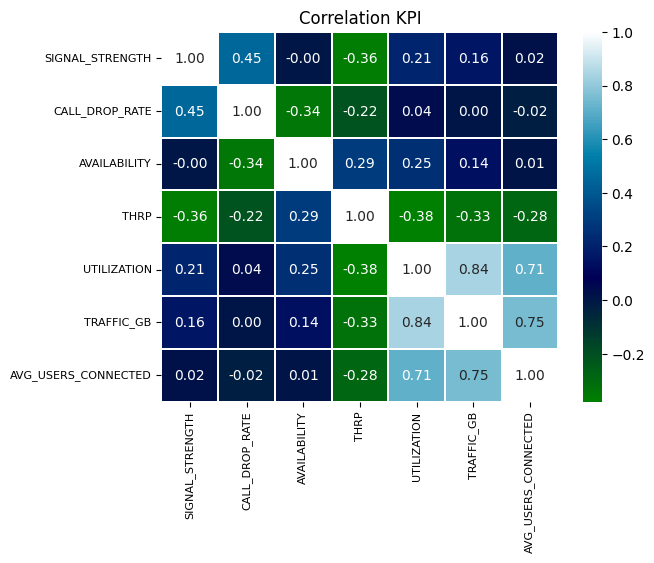

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

data = df_kpi
correlation_matrix = data.corr()

plt.title("Correlation KPI")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
sns.heatmap(correlation_matrix, annot=True, cmap='ocean', fmt='.2f', linewidths=0.2)
plt.show()

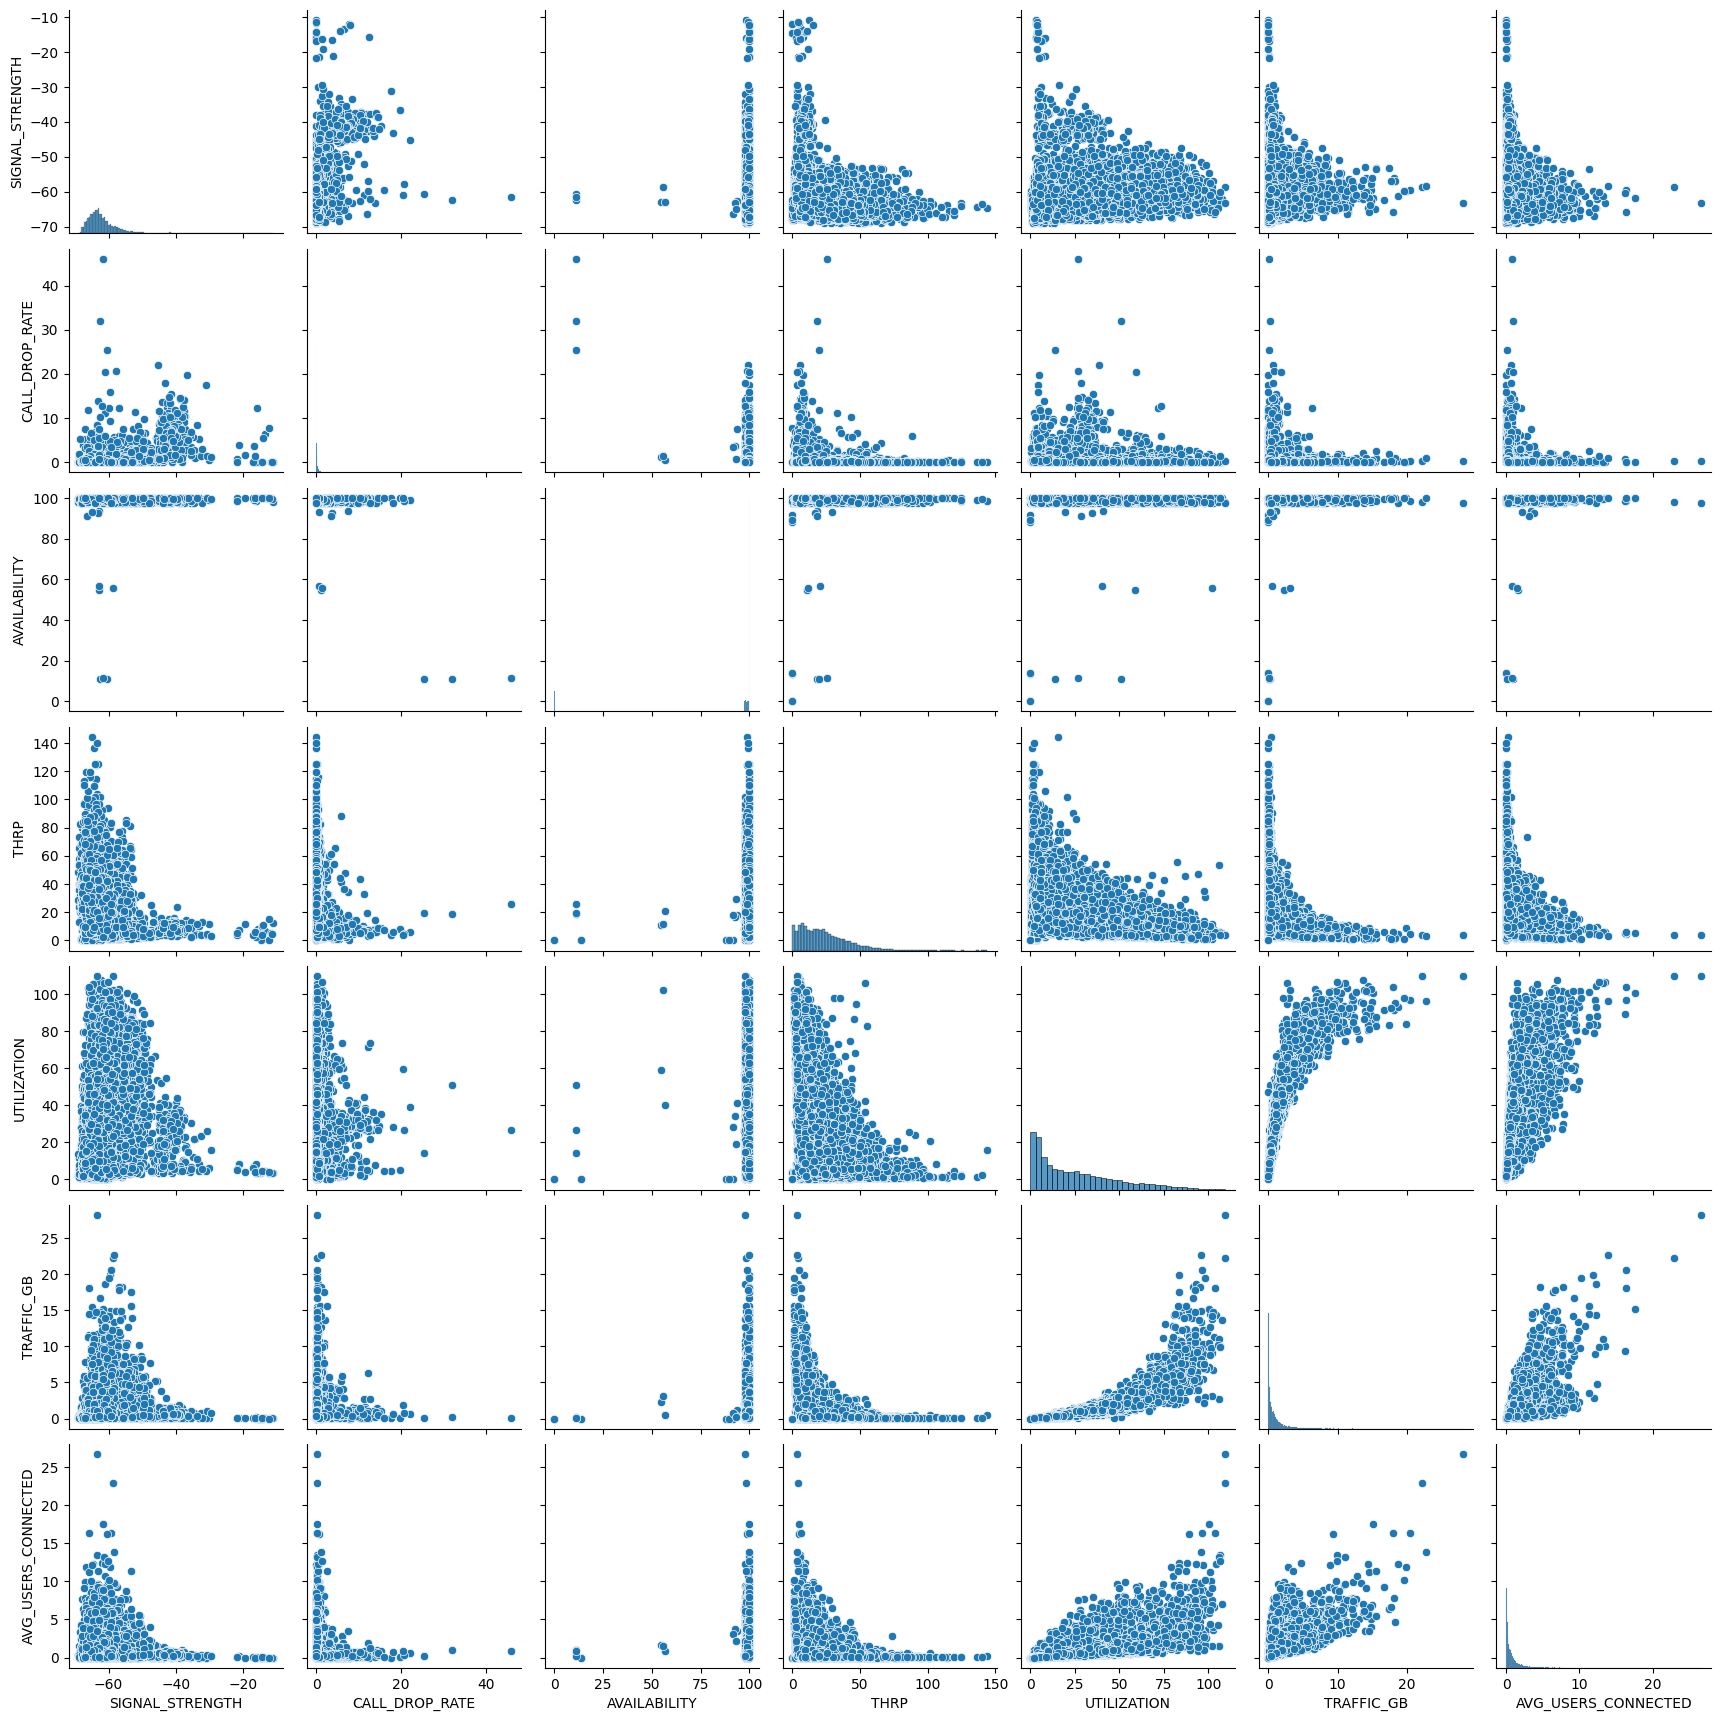

In [46]:
data=df_kpi
sns.pairplot(data, diag_kind='hist')
plt.show()

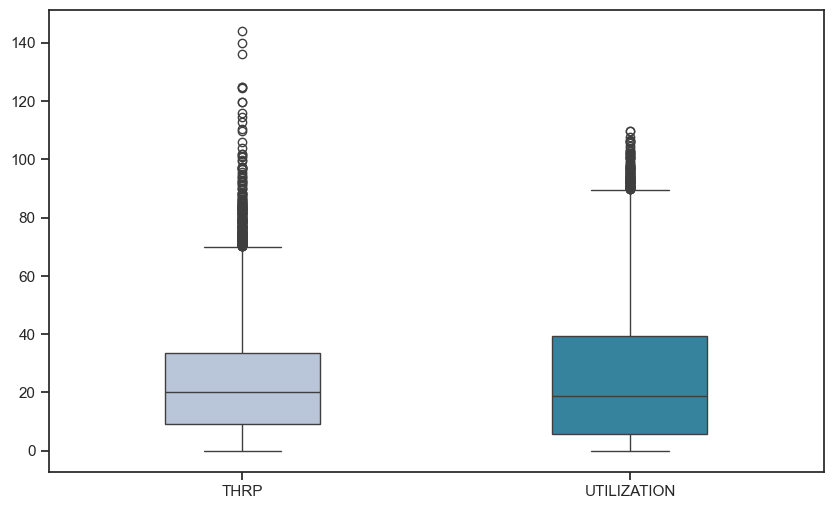

In [47]:
sns.set_theme(style="ticks")
plt.subplots(figsize=(10, 6))
data = df_kpi[['THRP','UTILIZATION']]

sns.boxplot(data, width=.4, palette="PuBuGn")

plt.show()

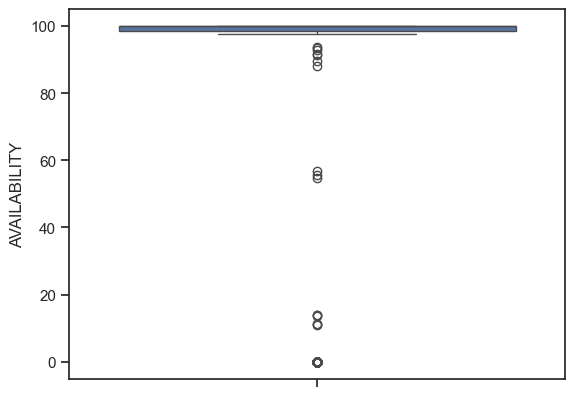

In [48]:
data = df_kpi['AVAILABILITY']
sns.boxplot(data)
plt.show()

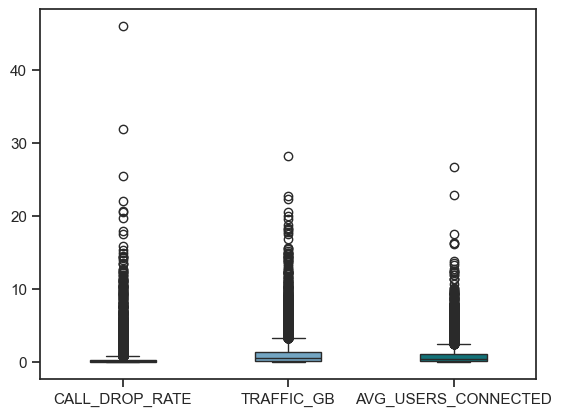

In [49]:
sns.set_theme(style="ticks")
data = df_kpi[['CALL_DROP_RATE','TRAFFIC_GB','AVG_USERS_CONNECTED']]

sns.boxplot(data, width=.4, palette="PuBuGn")

plt.show()

# NORMALIZATION

In [50]:
#delete columns in the Config table that are duplicated in EL_ID
df_config = df_config.drop(columns=['EL', 'EL_number'])
df_config.head()

,EL_TYPE,latitude,longitude,MCC,MNC,TILT,EL_ID,ADDRESS_ID
0,A,49.66256,27.20366,255,1,18,APHTV_80,1
1,A,49.66256,27.20366,255,1,10,APHTV_83,1
2,A,49.66256,27.20366,255,1,-4,APHTV_86,1
3,B,49.66256,27.20366,255,1,26,APHTV_124,1
4,B,49.66256,27.20366,255,1,1,APHTV_126,1


In [51]:
#grouping dates by hour in the Users table
df_users = (df_users.groupby('EL_ID') \
                   .resample('h', on='DT') \
                   .mean(numeric_only=True) \
                   .reset_index()) 
df_users.head()

,EL_ID,DT,AVG_USERS_CONNECTED
0,APHTV_124,2022-09-05 00:00:00,0.034956
1,APHTV_124,2022-09-05 01:00:00,0.024994
2,APHTV_124,2022-09-05 02:00:00,0.001158
3,APHTV_124,2022-09-05 03:00:00,0.000000
4,APHTV_124,2022-09-05 04:00:00,0.000000


In [52]:
#join coordinates for the Regions table
df_regions = pd.merge(df_regions, df_сoordinates, how='left', on=['ADDRESS_ID'])
df_regions.head()

,ADDRESS_ID,CITY,REGION,latitude,longitude
0,1,Миролюбне,Хмельницька область,49.66256,27.20366
1,2,Хижинці,Вінницька область,49.16643,28.55793
2,3,Гришківці,Житомирська область,49.93782,28.60615
3,4,Красівка,Житомирська область,49.90080,28.83431
4,5,Куманівка,Вінницька область,49.65106,28.68210


In [53]:
#delete columns with coordinates in the Config table
df_config = df_config.drop(columns=['latitude', 'longitude'])
df_config.head()

,EL_TYPE,MCC,MNC,TILT,EL_ID,ADDRESS_ID
0,A,255,1,18,APHTV_80,1
1,A,255,1,10,APHTV_83,1
2,A,255,1,-4,APHTV_86,1
3,B,255,1,26,APHTV_124,1
4,B,255,1,1,APHTV_126,1


# Loading into SQL

In [54]:
#saving all NaN to None to avoid loading errors in PostgreSQL
df.where(pd.notnull(df), None).head()

,DT,EL_ID,N_AVAILABILITY,D_AVAILABILITY,SIGNAL_STRENGTH,CALL_DROP_RATE,N_THRP,D_THRP,N_UTILIZATION,D_UTILIZATION,SIGNAL_QUALITY
0,2022-09-05,QSRUH_124,3513.7,3600.0,-58.223455,0.063925,9212.195510,1.178547,612.6732,23.920,Excellent
1,2022-09-05,QSRUH_126,3600.0,3600.0,-48.331428,0.357634,4822.563735,0.590651,429.2832,21.850,Excellent
2,2022-09-05,QSRUH_127,3600.0,3600.0,-60.619392,0.000000,6272.371920,0.955548,678.6116,29.975,Good
3,2022-09-05,QSRUH_80,3560.5,3600.0,-67.042051,0.000000,27212.310354,0.490053,1558.5576,108.070,Good
4,2022-09-05,QSRUH_83,3549.4,3600.0,-66.122174,0.034986,38705.333738,0.791987,2205.6992,97.850,Good


In [55]:
df_users.where(pd.notnull(df), None).head()
df_users.head()

,EL_ID,DT,AVG_USERS_CONNECTED
0,APHTV_124,2022-09-05 00:00:00,0.034956
1,APHTV_124,2022-09-05 01:00:00,0.024994
2,APHTV_124,2022-09-05 02:00:00,0.001158
3,APHTV_124,2022-09-05 03:00:00,0.000000
4,APHTV_124,2022-09-05 04:00:00,0.000000


In [57]:
#loading to SQL
from sqlalchemy import create_engine, text
from config import POSTGRES_USER, POSTGRES_PASSWORD

host = "localhost"
port = "5432"
database = "postgres"

def connect():
    try:
        engine = create_engine(f'postgresql://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{host}:{port}/{database}')
        conn = engine.connect()
        print("Connection to PostgreSQL is successful!")
        return conn, engine 
    except Exception as e:
        print(f"Connection error: {e}")
        return None, None

def create_database(conn, new_database):
    if conn:
        conn.execute(text("COMMIT;"))
        conn.execute(text(f"CREATE DATABASE {new_database};"))
        print(f"Database '{new_database}' has been successfully created!")
    else:
        print("Database creation failed.")


new_database = "mobile_stat"
conn,engine = connect()
create_database(conn, new_database)

Connection to PostgreSQL is successful!
Database 'mobile_stat' has been successfully created!


In [58]:
#connecting to a new database
def connect_new_bd(new_database): 
    engine = create_engine(f'postgresql://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{host}:{port}/{new_database}')
    conn = engine.connect()
    print("Connection to new database is successful!")
    return conn, engine
     

conn, engine = connect_new_bd(new_database)

Connection to new database is successful!


In [59]:
df.to_sql(name='performance', con=engine, if_exists='replace', index=False)

585

In [60]:
df_traffic.to_sql(name='traffic', con=engine, if_exists='replace', index=False)

585

In [61]:
df_users.to_sql(name='users', con=engine, if_exists='replace', index=False)

584

In [62]:
df_config.to_sql(name='config', con=engine, if_exists='replace', index=False)

63

In [63]:
df_regions.to_sql(name='regions', con=engine, if_exists='replace', index=False)

16

# Saving

In [64]:
with pd.ExcelWriter(r'D:\Data Analyst\Projects\mobile_stat_cleaned.xlsx', engine='xlsxwriter') as writer:

    df.to_excel(writer, sheet_name='Performance', index=False)
    df_traffic.to_excel(writer, sheet_name='Traffic', index=False)
    df_users.to_excel(writer, sheet_name='Users', index=False)
    df_config.to_excel(writer, sheet_name='Config', index=False)
    df_regions.to_excel(writer, sheet_name='Regions', index=False)